In [9]:
import numpy as np
import matplotlib.pyplot as plt
from graspy.inference import SemiparametricTest
from graspy.embed import AdjacencySpectralEmbed, select_dimension
import seaborn as sns
import warnings
from graspy.simulations import binary_sbm, rdpg_from_latent
from graspy.utils import symmetrize
import time
import pandas as pd


warnings.filterwarnings("ignore")
FONTSIZE = 30

def double_plot(A, X):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    sns.heatmap(A, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    sns.scatterplot(X[:,1], X[:,2], ax=ax[1],alpha = 0.5,s=100)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[0].set_title('Adjacency matrix', fontsize=FONTSIZE)
    ax[1].set_title('Adjacency spectral embedding',fontsize=FONTSIZE)
    return ax

def adj_plot(A, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(A, ax=ax, xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    if title is None: 
        title = 'Adjacency matrix'
    ax.set_title(title, fontsize=FONTSIZE)
    return ax

# From *A Semiparametric Two-Sample Hypothesis Testing Problem for Random Graphs* (Tang et al. 2017)

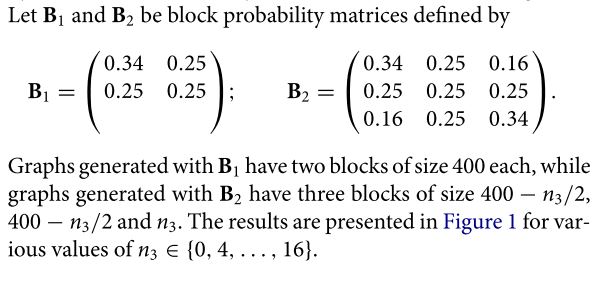

In [61]:
from IPython.display import Image, display
display(Image(filename='rdpg.jpg', embed=True))

In [13]:
# works when setting bottom right corner of B2 to 0.8, n3s to [0 40 80 120 160] n_components to 6
# works similarly when n_components is 10

# with bottom right at 0.8, n3s at [0, 10, 20, 40, 80], n_components = 10, can see first few overlapping and then start to diverge
# all of the above using 'scalar-rotation'

# note that I am changing the bottom right corner p to 0.6 for an even greater difference than the paper
# also, using higher block membership numbers than the paper
# effect should be much bigger than figure above, for these reasons
B1 = np.array([[0.34, 0.25],
               [0.25, 0.25]])
B2 = np.array([[0.34, 0.25, 0.16],
               [0.25, 0.25, 0.25],
               [0.16, 0.25, 0.6]])
n1 = 400
n2 = 400
n3s = [0, 10, 20, 30, 40, 50, 60, 70, 80,]

n_sims = 500

n_components = 6

T_dist = np.zeros((n_sims, len(n3s)))
T2_dist = np.zeros((n_sims, len(n3s)))

t = time.process_time()


for n_ind, n3 in enumerate(n3s):
    print('Working on {}'.format(n_ind))
    for sim in range(n_sims):
        A1 = binary_sbm([n1,n2], B1)
        if n3 == 0:
            A2 = binary_sbm([n1,n2], B1)
        else:
            communities = [(n1 - n3//2), (n2 - n3//2), n3]
            if sim == 0:
                print(communities)
#                 adj_plot(A1, title='Adjacency matrix 1')
#                 adj_plot(A2, title='Adjacency matrix 2')
            A2 = binary_sbm(communities, B2)
        if n_components is None: 
            num_dims1 = select_dimension(A1)[0][-1]
            num_dims2 = select_dimension(A2)[0][-1]
            n_components = max(num_dims1, num_dims2)
        
        spt = SemiparametricTest(n_components=n_components, test_case='scalar-rotation')
        X1hat, X2hat = spt._embed(A1, A2)
        T = spt._difference_norm(X1hat, X2hat)
        T_dist[sim, n_ind] = T
        # just making sure the order doesnt matter much
        T2 = spt._difference_norm(X2hat, X1hat)
        T2_dist[sim, n_ind] = T2
        
print('{0:.3f} mins'.format(((time.process_time() - t)/60)))
#     t = time.process_time()
#     spt = SemiparametricTest(n_bootstraps=bs, n_components=n_components)
#     spt.fit(A1, A2)
#     print('{0:.3f} mins'.format(((time.process_time() - t)/60)))
#     B1_graphs.append(A1)
#     B2_graphs.append(A2)
#     tests.append(spt)
    

Working on 0
Working on 1
[395, 395, 10]
Working on 2
[390, 390, 20]
Working on 3
[385, 385, 30]
Working on 4
[380, 380, 40]
Working on 5
[375, 375, 50]
Working on 6
[370, 370, 60]
Working on 7
[365, 365, 70]
Working on 8
[360, 360, 80]
59.844 mins


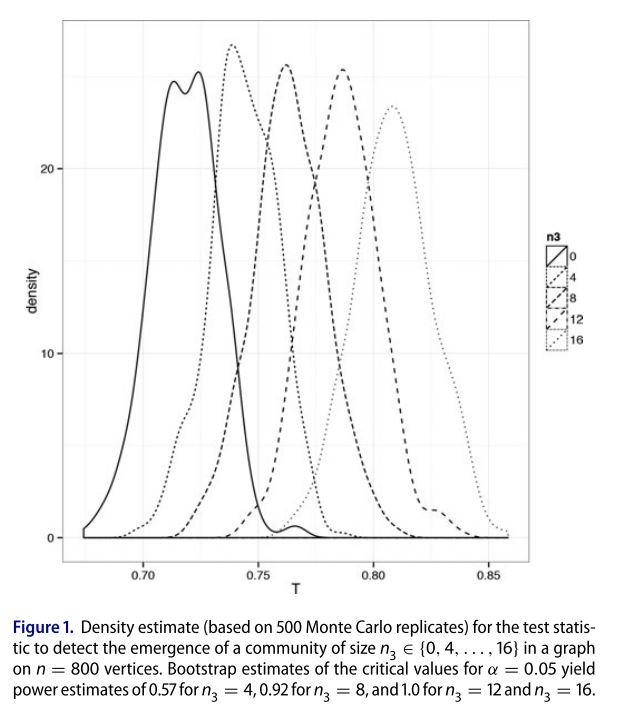

In [62]:
display(Image(filename='results.jpg', embed=True))

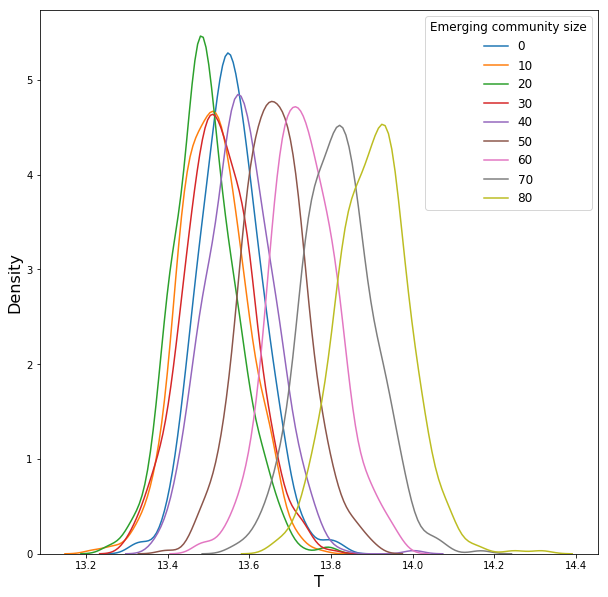

In [24]:
ax = plt.subplots(1,1,figsize=(10,10))[1]
# kde_kws = {'linestyle':'dashed'}
for idx, _ in enumerate(n3s):
#     print('n3 = {}'.format(n3s[idx]))
#     print('p = {}'.format(spt.p))
#     print('sample T statistic = {}'.format(spt.T_sample))
#     print('')
#     sns.distplot(spt.T1_bootstrap, ax=ax, hist=False, norm_hist=True, label='T1'+str(n3s[idx]), kde_kws=kde_kws)
    sns.distplot(T_dist[:,idx], ax=ax, hist=False, norm_hist=True, label=str(n3s[idx]))#label='T2'+str(n3s[idx]))
    ax.set_xlabel('T', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
l = plt.legend(title='Emerging community size', fontsize=12)
l.get_title().set_fontsize(12) 
plt.show()

In [41]:
def get_block_probs(eps):
    B = np.array([[0.3+eps, 0.2],
                  [0.2, 0.3+eps]])
    return B

n_components = 4
n_bootstraps = 500
sizes = [250,250]
Bx = get_block_probs(0)
epsilons = [0, 0.05, 0.1, 0.2]
tests = []
for eps in epsilons:
    print('Epsilon = {}'.format(eps))
    By = get_block_probs(eps)
    Ax = binary_sbm(sizes,Bx)
    Ay = binary_sbm(sizes,By)
    spt = SemiparametricTest(n_components=n_components, n_bootstraps=500)
    spt.fit(Ax, Ay)
    tests.append(spt)

Epsilon = 0
Epsilon = 0.05
Epsilon = 0.1
Epsilon = 0.2


In [54]:
[print(test.p) for test in tests]

0.003
0.001
0.001
0.001


[None, None, None, None]